In [1]:
CUDA_ID = 6
SEED = 2023
TDDPM_DIR = "/home/liu00980/Documents/multimodal/tabular/tab-ddpm/"
SYNINF_DIR = (
    "/home/liu00980/Documents/multimodal/tabular/tab-ddpm/pass-inference/syninf"
)

In [2]:

import torch

torch.cuda.set_device(CUDA_ID)


import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import quantile_transform
from scipy.stats import norm

from lightning.pytorch import seed_everything

import time
from copy import deepcopy
import os
import shutil
from tqdm import tqdm
import json
import pickle

import seaborn as sns
import matplotlib.pyplot as plt


from sample import TrueSampler

import sys

sys.path.insert(0, SYNINF_DIR)

from utils_syninf import (
    train_tabddpm,
    generate_sample,
    concat_data,
    catboost_pred_model,
    blackbox_test_stat,
)
from utils_num import wasserstein_2_distance
from utils_viz import compare_distributions_grid, heatmap_correlation

In [3]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Get original data and pre-training data ready
* Original data: 1000 training + 200 inference
* Pre-training size $n_h = 10000$ + **SAME** inference set (as validation)

In [4]:
sigma = 0.2
n_pretrain = 10000  # pre-training size
keyword = f"inf_{n_pretrain}"
synthetic_sample_dir = f"./ckpt/{keyword}/"


n_train = 1000  # raw training size
n_val = 200  # validation size
n_test = 1000  # test or evaluation size

In [5]:
true_sampler = TrueSampler(sigma=sigma, null_feature=True)

seed_everything(SEED)

X_pretrain, y_pretrain = true_sampler.sample(n_pretrain)
X_train, y_train = true_sampler.sample(n_train)
X_val, y_val = true_sampler.sample(n_val)
X_test, y_test = true_sampler.sample(n_test)

# Raw data
raw_data_dir = os.path.join(TDDPM_DIR, f"data/inf_raw")

os.makedirs(raw_data_dir, exist_ok=True)

print(f"Saving raw data to {raw_data_dir} ...")

np.save(os.path.join(raw_data_dir, "X_num_train.npy"), X_train)
np.save(os.path.join(raw_data_dir, "y_train.npy"), y_train)

np.save(os.path.join(raw_data_dir, "X_num_val.npy"), X_val)
np.save(os.path.join(raw_data_dir, "y_val.npy"), y_val)

np.save(os.path.join(raw_data_dir, "X_num_test.npy"), X_test)
np.save(os.path.join(raw_data_dir, "y_test.npy"), y_test)

info_dict = {
    "task_type": "regression",
    "name": "inf_raw",
    "id": "inf_raw",
    "train_size": n_train,
    "val_size": n_val,
    "test_size": n_test,
    "n_num_features": X_test.shape[1],
}
print(f"Saving raw dataset meta information to {raw_data_dir} ...")
json.dump(info_dict, open(os.path.join(raw_data_dir, "info.json"), "w"))


# Pre-training data
pretrain_data_dir = os.path.join(TDDPM_DIR, f"data/inf_{n_pretrain}")

os.makedirs(pretrain_data_dir, exist_ok=True)

print(f"Saving pre-training data to {pretrain_data_dir} ...")

np.save(os.path.join(pretrain_data_dir, "X_num_train.npy"), X_pretrain)
np.save(os.path.join(pretrain_data_dir, "y_train.npy"), y_pretrain)

np.save(os.path.join(pretrain_data_dir, "X_num_val.npy"), X_val)
np.save(os.path.join(pretrain_data_dir, "y_val.npy"), y_val)

np.save(os.path.join(pretrain_data_dir, "X_num_test.npy"), X_test)
np.save(os.path.join(pretrain_data_dir, "y_test.npy"), y_test)

info_dict = {
    "task_type": "regression",
    "name": f"inf_{n_pretrain}",
    "id": f"inf_{n_pretrain}",
    "train_size": n_pretrain,
    "val_size": n_val,
    "test_size": n_test,
    "n_num_features": X_test.shape[1],
}
print(f"Saving pre-training dataset meta information to {pretrain_data_dir} ...")
json.dump(info_dict, open(os.path.join(pretrain_data_dir, "info.json"), "w"))

Seed set to 2023


X shape:  (10000, 8)
y shape:  (10000,)
X shape:  (1000, 8)
y shape:  (1000,)
X shape:  (200, 8)
y shape:  (200,)
X shape:  (1000, 8)
y shape:  (1000,)
Saving raw data to /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/inf_raw ...
Saving raw dataset meta information to /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/inf_raw ...
Saving pre-training data to /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/inf_10000 ...
Saving pre-training dataset meta information to /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/inf_10000 ...


## Get twin folders ready

In [6]:

raw_data_dir = os.path.join(TDDPM_DIR, f"data/inf_raw")

info_dict = json.load(open(os.path.join(raw_data_dir, "info.json"), "r"))
X_train = np.load(os.path.join(raw_data_dir, "X_num_train.npy"))
y_train = np.load(os.path.join(raw_data_dir, "y_train.npy"))

m = int(X_train.shape[0] / 2)

for twin_kw in ["twin_1", "twin_2"]:
    print(f"Preparing twin data directories for {raw_data_dir}: {twin_kw} ...")
    
    twin_data_dir = os.path.join(TDDPM_DIR, f"data/inf_raw_{twin_kw}")
    shutil.copytree(raw_data_dir, twin_data_dir, dirs_exist_ok=True)
    
    temp_info_dict = deepcopy(info_dict)
    temp_info_dict["name"] = f"inf_{twin_kw}"
    temp_info_dict["id"] = f"inf_{twin_kw}"
    
    if twin_kw == "twin_1":
        X_temp, y_temp = X_train[:m], y_train[:m]
        temp_info_dict["train_size"] = m
    else:
        X_temp, y_temp = X_train[m:], y_train[m:]
        temp_info_dict["train_size"] = X_train.shape[0] - m
    
    np.save(os.path.join(twin_data_dir, "X_num_train.npy"), X_temp)
    np.save(os.path.join(twin_data_dir, "y_train.npy"), y_temp)
    json.dump(temp_info_dict, open(os.path.join(twin_data_dir, "info.json"), "w"))
    

Preparing twin data directories for /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/inf_raw: twin_1 ...
Preparing twin data directories for /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/inf_raw: twin_2 ...


# Get the pre-trained generator

In [9]:
train_tabddpm(
    pipeline_config_path="./ckpt/base_config.toml",
    real_data_dir=pretrain_data_dir,
    steps=50000,
    temp_parent_dir=synthetic_sample_dir,
    device=f"cuda:{CUDA_ID}",
    seed=SEED,
)

Use category sizes from the training set: [0]
9
{'d_in': 9, 'num_classes': 0, 'is_y_cond': False, 'rtdl_params': {'d_layers': [512, 256, 256, 256, 256, 128], 'dropout': 0.0}}
mlp


Step 500/50000 MLoss: 0.0 GLoss: 0.4786 Sum: 0.4786
Step 1000/50000 MLoss: 0.0 GLoss: 0.4756 Sum: 0.4756
Step 1500/50000 MLoss: 0.0 GLoss: 0.4754 Sum: 0.4754
Step 2000/50000 MLoss: 0.0 GLoss: 0.4763 Sum: 0.4763
Step 2500/50000 MLoss: 0.0 GLoss: 0.4749 Sum: 0.4749
Step 3000/50000 MLoss: 0.0 GLoss: 0.4744 Sum: 0.4744
Step 3500/50000 MLoss: 0.0 GLoss: 0.474 Sum: 0.474
Step 4000/50000 MLoss: 0.0 GLoss: 0.4751 Sum: 0.4751
Step 4500/50000 MLoss: 0.0 GLoss: 0.4733 Sum: 0.4733
Step 5000/50000 MLoss: 0.0 GLoss: 0.4738 Sum: 0.4738
Step 5500/50000 MLoss: 0.0 GLoss: 0.4722 Sum: 0.4722
Step 6000/50000 MLoss: 0.0 GLoss: 0.4711 Sum: 0.4711
Step 6500/50000 MLoss: 0.0 GLoss: 0.4707 Sum: 0.4707
Step 7000/50000 MLoss: 0.0 GLoss: 0.4705 Sum: 0.4705
Step 7500/50000 MLoss: 0.0 GLoss: 0.47 Sum: 0.47
Step 8000/50000 MLoss: 0.0 GLoss: 0.4704 Sum: 0.4704
Step 8500/50000 MLoss: 0.0 GLoss: 0.4674 Sum: 0.4674
Step 9000/50000 MLoss: 0.0 GLoss: 0.4686 Sum: 0.4686
Step 9500/50000 MLoss: 0.0 GLoss: 0.4688 Sum: 0.4688


'./ckpt/inf_10000/'

## Visually check the performance of pre-trained generator

In [10]:
generate_sample(
    pipeline_config_path=f"./ckpt/{keyword}/config.toml",
    ckpt_path=f"./ckpt/{keyword}/model.pt",
    num_samples=10000,
    batch_size=10000,
    temp_parent_dir=synthetic_sample_dir,
    device=f"cuda:{CUDA_ID}",
    seed=SEED,
)

Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10000, 8)


'./ckpt/inf_10000/'

In [11]:
true_df = concat_data(pretrain_data_dir, split="train")
synthetic_df = concat_data(synthetic_sample_dir, split="train")

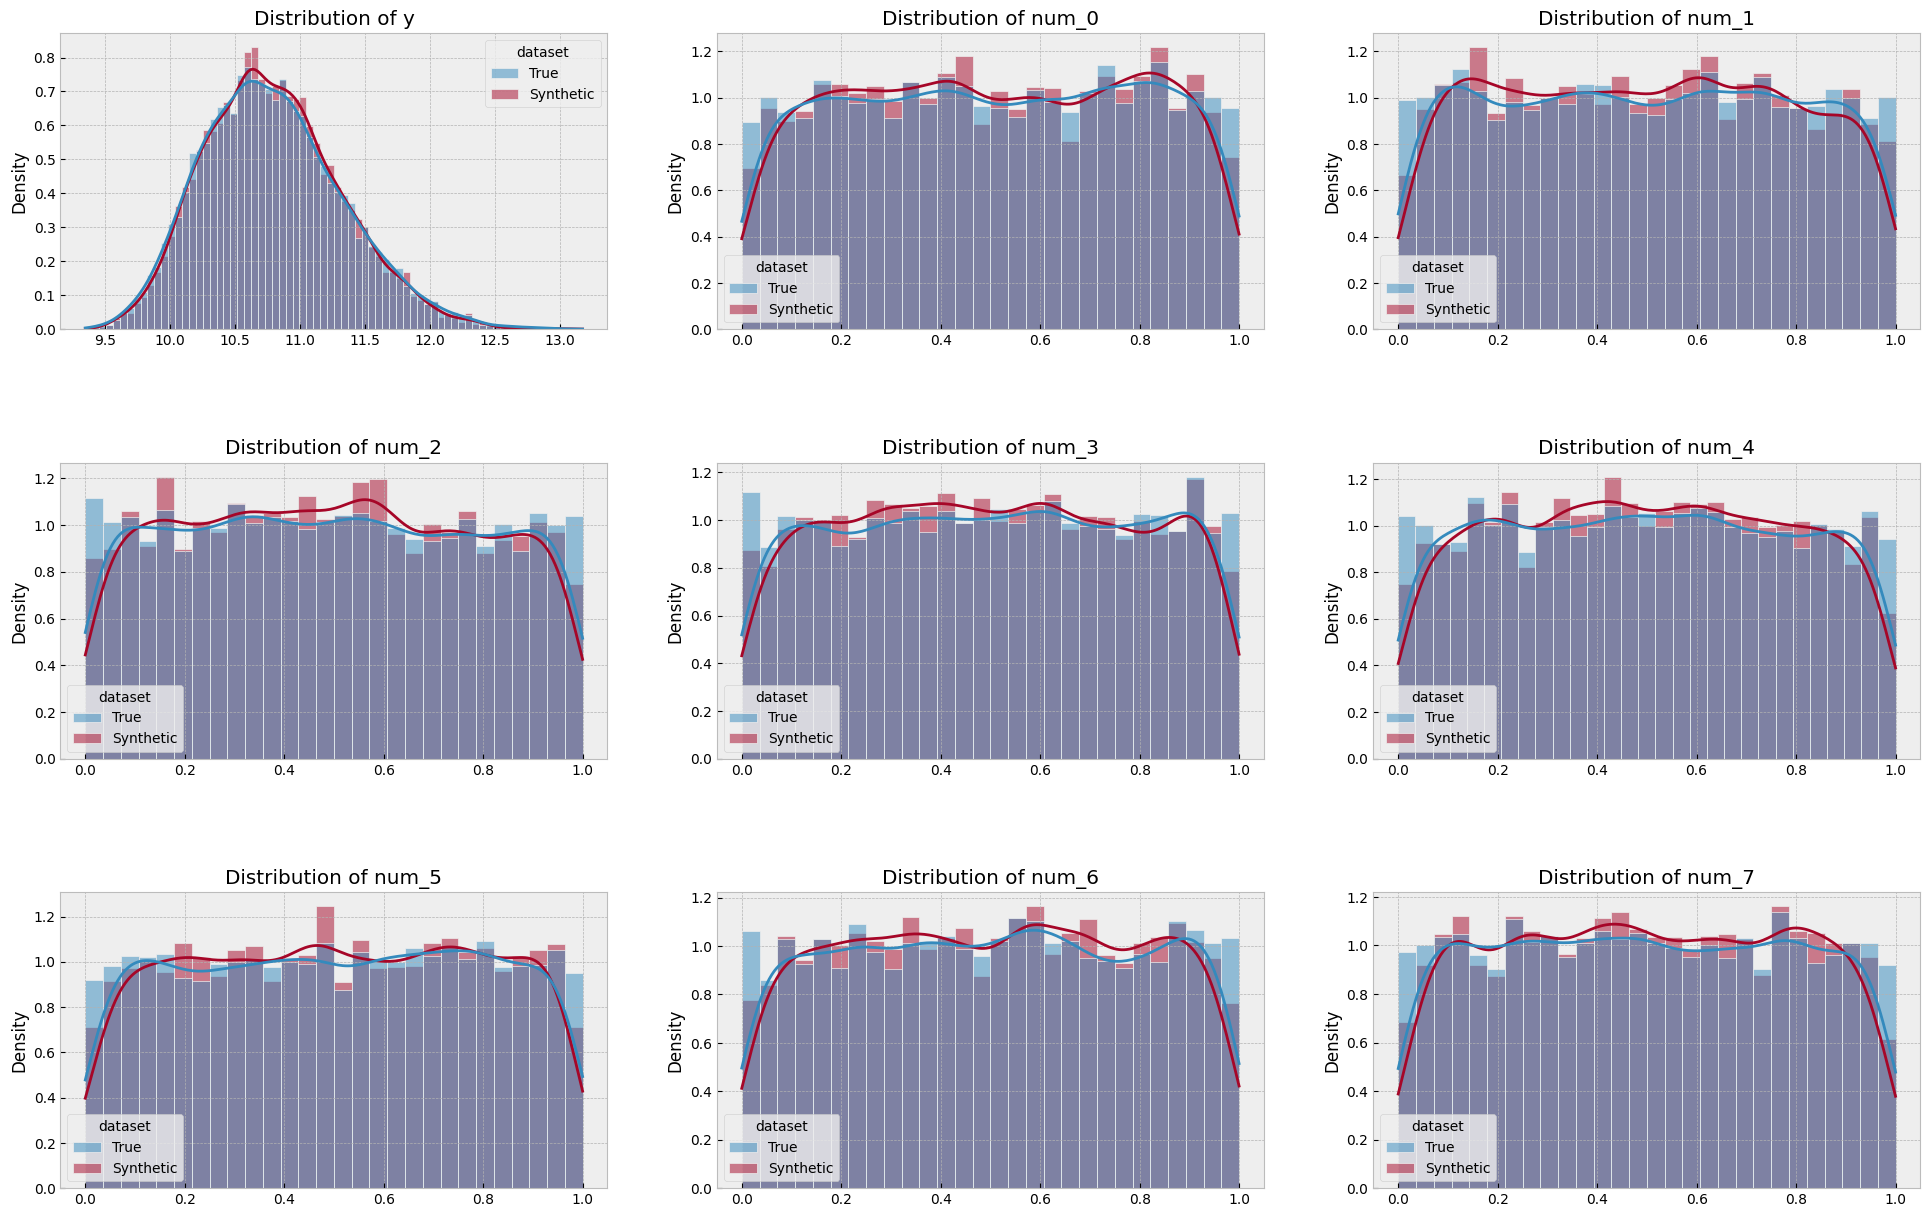

In [12]:
compare_distributions_grid([true_df, synthetic_df], ["True", "Synthetic"], 3, 3)

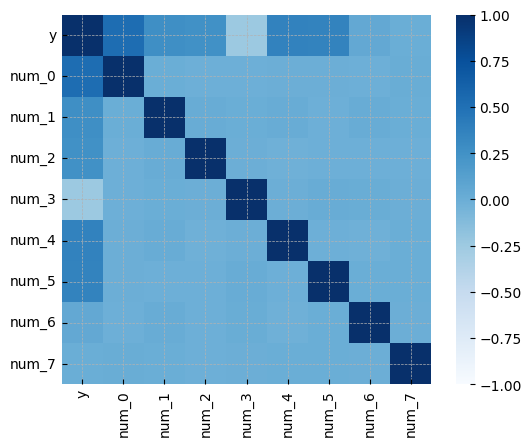

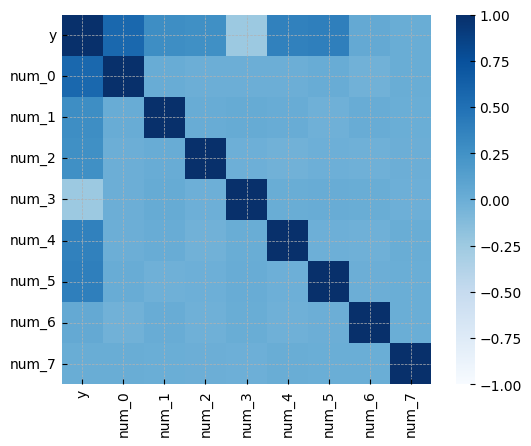

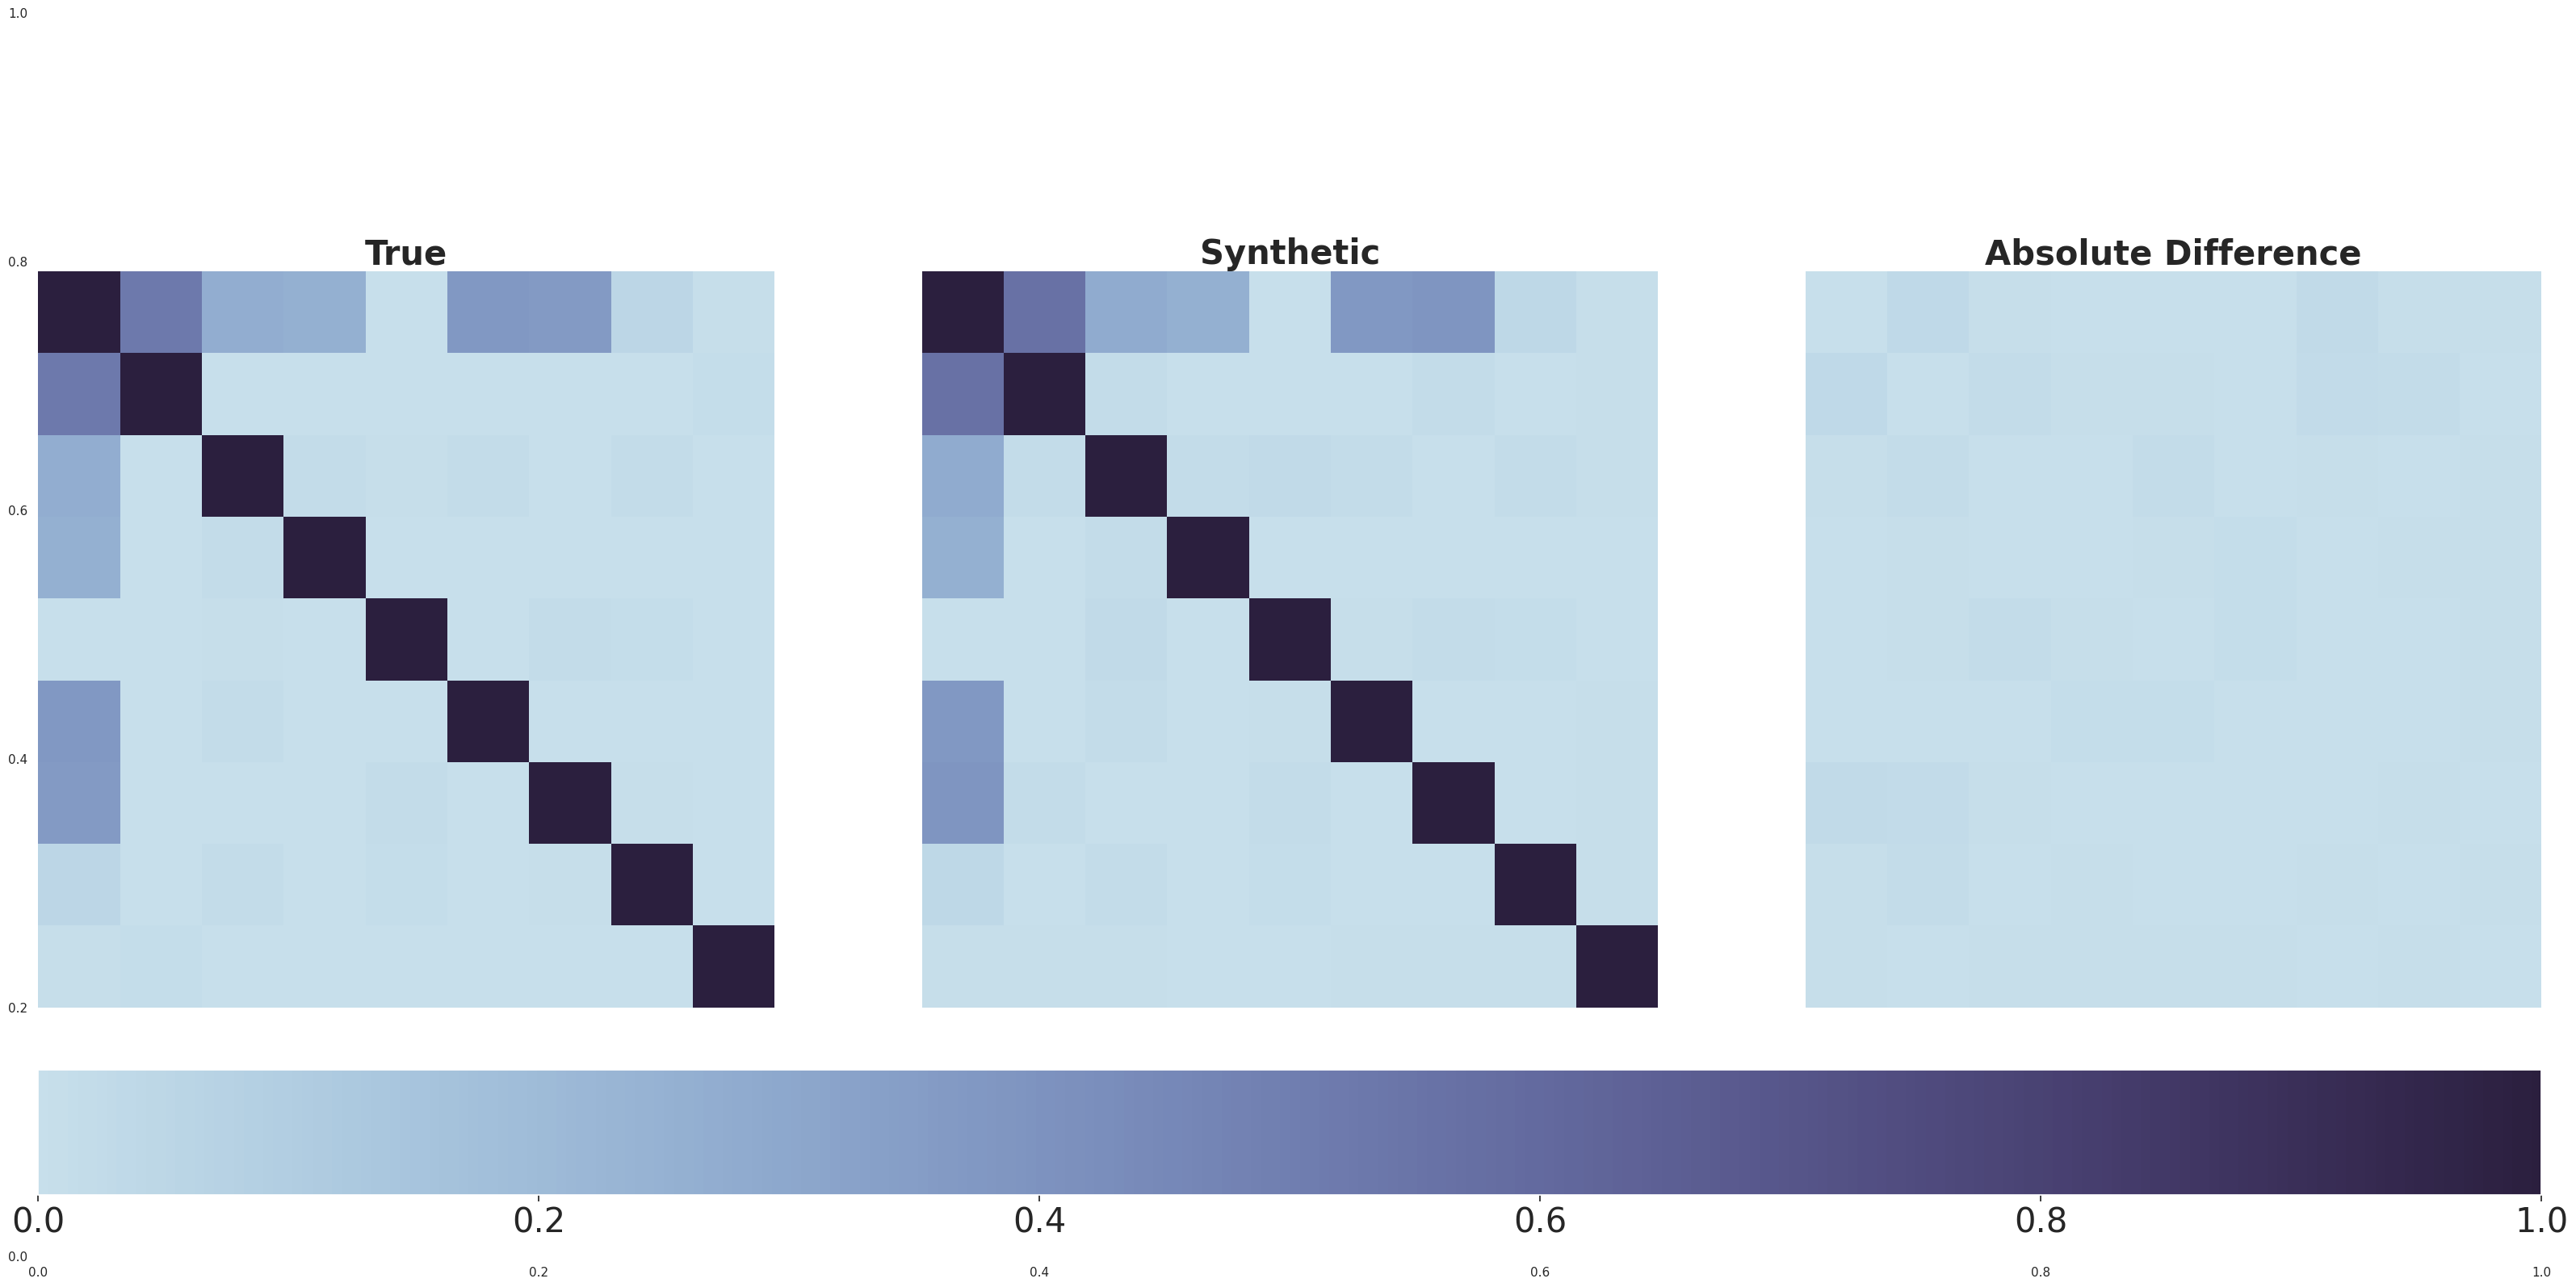

In [13]:
heatmap_correlation(true_df, synthetic_df, "True", "Synthetic")

# Syn-Test

In [7]:
# keyword = "inf_2000"
keyword = "inf_10000"
ckpt_dir = f"./ckpt/{keyword}"

## Fine-tune and get twin generators

Obtain the twin generators

In [8]:

# when generating samples, one should use the SAME PRE-PROCESSING pipeline during fine-tuning
for twin_kw in ["twin_1", "twin_2"]:
    print(f"Fine-tuning pre-trained generator {keyword} for {twin_kw} ...")
    train_tabddpm(
        pipeline_config_path=os.path.join(ckpt_dir, "config.toml"),
        real_data_dir= os.path.join(TDDPM_DIR, f"data/inf_raw_{twin_kw}"),
        ckpt_path=os.path.join(ckpt_dir, "model.pt"),
        pipeline_dict_path=os.path.join(ckpt_dir, "pipeline_dict.joblib"),
        steps=1000,
        lr=3e-6,
        # lr=1e-7,
        temp_parent_dir=f"./ckpt/{keyword}_{twin_kw}",
        device=f"cuda:{CUDA_ID}",
        seed=SEED,
    )

Fine-tuning pre-trained generator inf_10000 for twin_1 ...
Loading numerical preprocessing pipeline from ./ckpt/inf_10000/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
9
{'d_in': 9, 'num_classes': 0, 'is_y_cond': False, 'rtdl_params': {'d_layers': [512, 256, 256, 256, 256, 128], 'dropout': 0.0}}
mlp
Loading model checkpoint from ./ckpt/inf_10000/model.pt
Step 500/1000 MLoss: 0.0 GLoss: 0.5168 Sum: 0.5168


Step 1000/1000 MLoss: 0.0 GLoss: 0.5064 Sum: 0.5064
Fine-tuning pre-trained generator inf_10000 for twin_2 ...
Loading numerical preprocessing pipeline from ./ckpt/inf_10000/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
9
{'d_in': 9, 'num_classes': 0, 'is_y_cond': False, 'rtdl_params': {'d_layers': [512, 256, 256, 256, 256, 128], 'dropout': 0.0}}
mlp
Loading model checkpoint from ./ckpt/inf_10000/model.pt
Step 500/1000 MLoss: 0.0 GLoss: 0.5108 Sum: 0.5108
Step 1000/1000 MLoss: 0.0 GLoss: 0.5009 Sum: 0.5009


Loading numerical preprocessing pipeline from ./ckpt/inf_10000/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10000, 8)


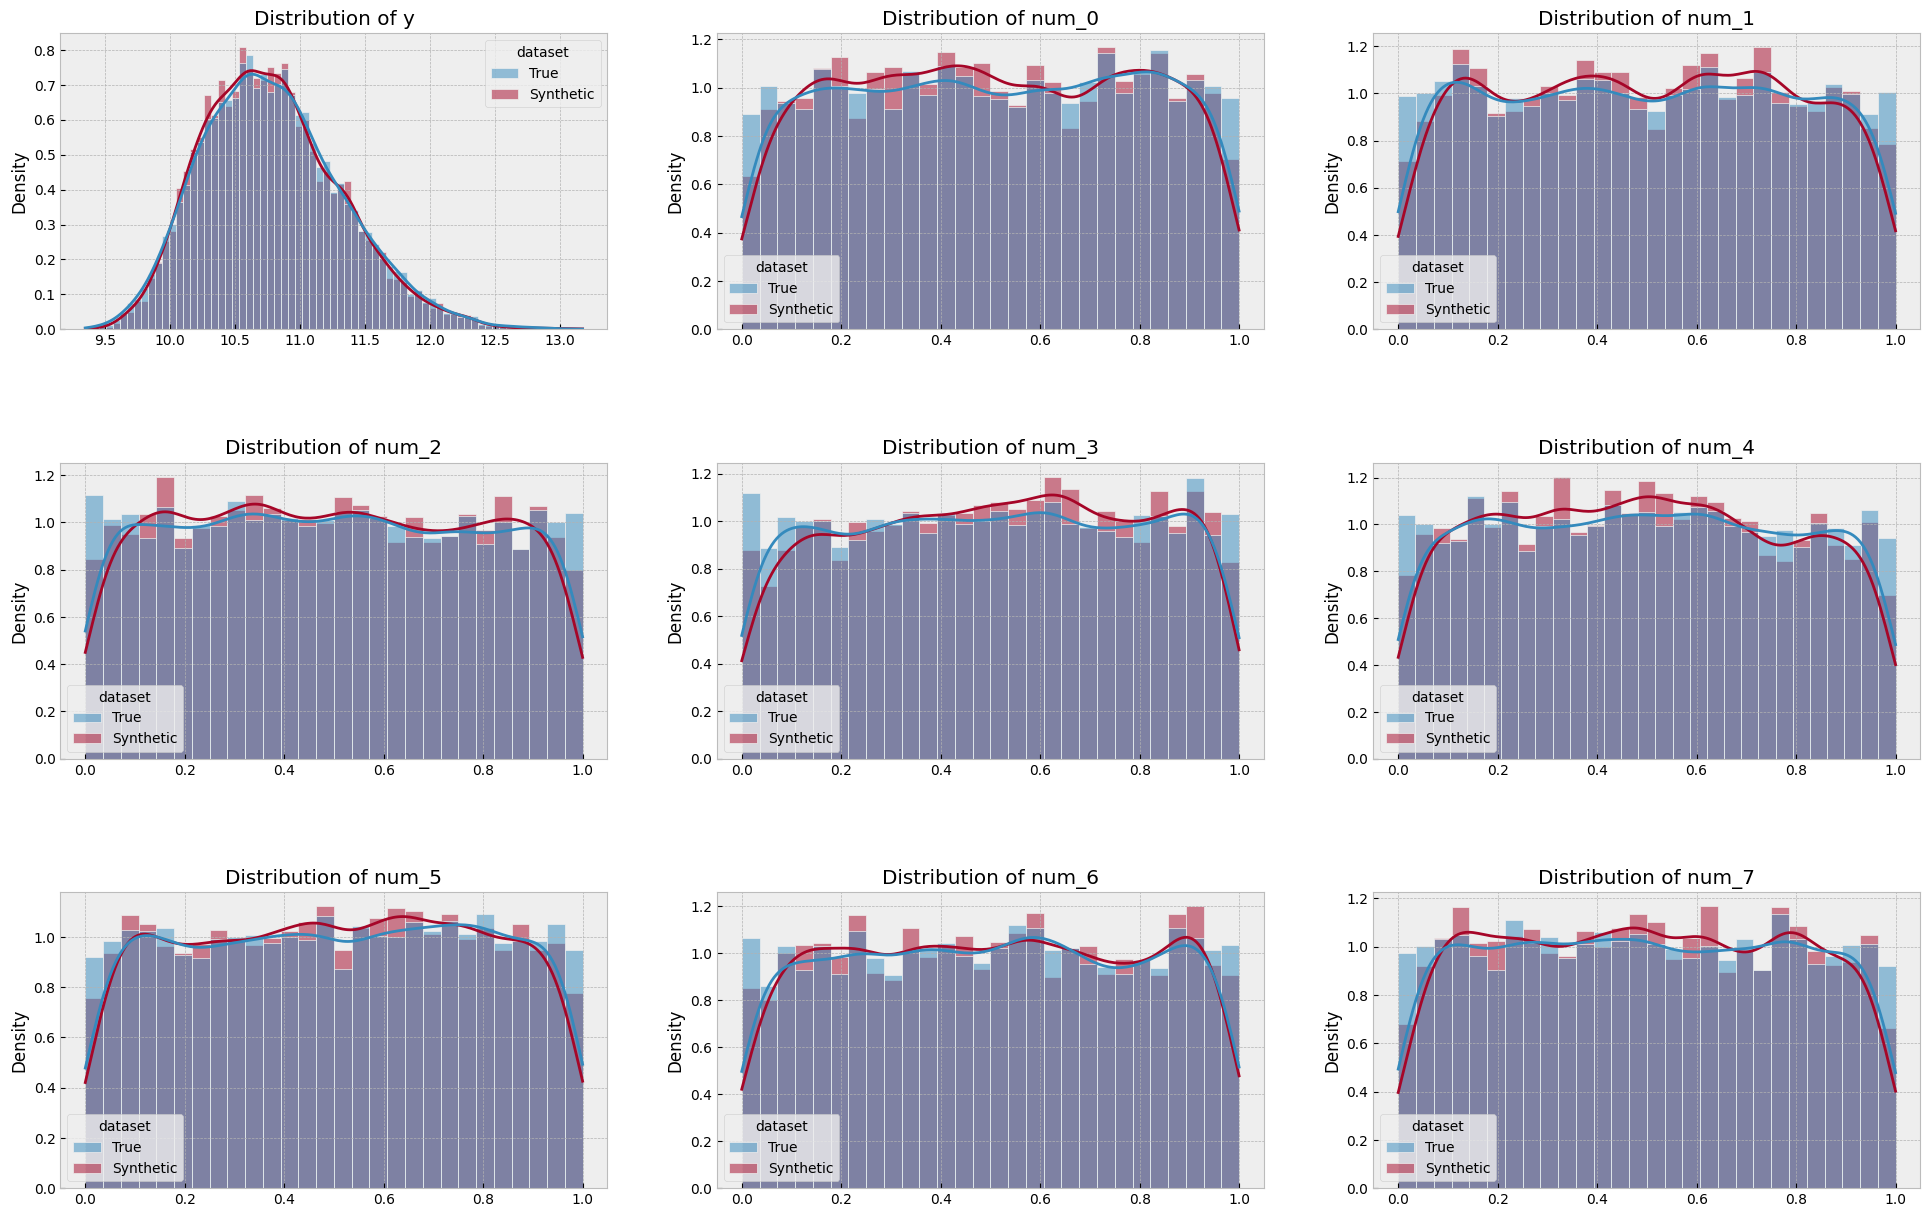

In [22]:
# Check performance of the fine-tuned generator
twin_kw = "twin_2"
generate_sample(
    pipeline_config_path=f"./ckpt/{keyword}_{twin_kw}/config.toml",
    ckpt_path=f"./ckpt/{keyword}_{twin_kw}/model.pt",
    pipeline_dict_path=os.path.join(ckpt_dir, "pipeline_dict.joblib"),
    num_samples=10000,
    batch_size=10000,
    temp_parent_dir="./temp/",
    device=f"cuda:{CUDA_ID}",
    seed=SEED,
)

synthetic_df = concat_data("./temp/", split="train")
# true_df = concat_data(pretrain_data_dir, split="train")
true_df = concat_data(pretrain_data_dir, split="train")

compare_distributions_grid([true_df, synthetic_df], ["True", "Synthetic"], 3, 3)


## Compare distributions of the test statistic

* Under size: 1000 (twin: 500 + 500) + 200
* Of three generators: true generator, learned generator (**twin_1**) and learned null generator (**twin_1**)
* For two candidate features: $X_7$ (significant, "num_6", on a second thought, this one is not indicative of the null distribution, so use the 8th feature only) and $X_8$ (insignificant, "num_7")

In [8]:
D = 500
null_features_list = ["num_7"] # versus ["num_6"]

kwargs = {
    "num_features_list": [f"num_{i}" for i in range(8)],
    "iterations": 1000,
    "loss_function": "MAE",
    "verbose": False,
}

# kwargs for generating samples using twin_1 tddpm
tddpm_kwargs = {
    "pipeline_config_path": f"./ckpt/{keyword}_twin_1/config.toml",
    "ckpt_path": f"./ckpt/{keyword}_twin_1/model.pt",
    "pipeline_dict_path": os.path.join(ckpt_dir, "pipeline_dict.joblib"), # same as the pre-processing pipeline during its fine-tuning
    "temp_parent_dir": "./temp/",
    "device": f"cuda:{CUDA_ID}",
}

comparison_dir = "./results/comparison/"

### True generator

In [134]:
np.random.seed(SEED)

test_stat_list = []
temp_save_dir = os.path.join(comparison_dir, "true")
if not os.path.exists(temp_save_dir):
    os.makedirs(temp_save_dir)

for d in tqdm(range(D)):
    with HiddenPrints():
        df_train = true_sampler.sample(n_train, return_df=True)
        df_inf = true_sampler.sample(n_val, return_df=True)

        model_full = catboost_pred_model(df_train, df_inf, **kwargs)
        model_partial = catboost_pred_model(
            df_train, df_inf, null_features_list=null_features_list, **kwargs
        )

    test_stat = blackbox_test_stat(df_inf, model_full, model_partial, **kwargs)
    test_stat_list.append(test_stat)
    pickle.dump(
        test_stat_list,
        open(
            os.path.join(temp_save_dir, f"{n_train}_{D}_{null_features_list[0]}.pkl"),
            "wb",
        ),
    )

100%|██████████| 2/2 [00:10<00:00,  5.35s/it]


### Learned generator

In [138]:
seed_everything(SEED)

test_stat_list = []
temp_save_dir = os.path.join(comparison_dir, "learned")
if not os.path.exists(temp_save_dir):
    os.makedirs(temp_save_dir)


for d in tqdm(range(D)):

    with HiddenPrints():
        generate_sample(num_samples=n_train, batch_size=n_train, seed = random.randint(0, 100000), **tddpm_kwargs)
        df_train = concat_data("./temp/", split="train")

        generate_sample(num_samples=n_val, batch_size=n_val, seed = random.randint(0, 100000), **tddpm_kwargs)
        df_inf = concat_data("./temp/", split="train")


        model_full = catboost_pred_model(df_train, df_inf, **kwargs)
        model_partial = catboost_pred_model(
            df_train, df_inf, null_features_list=null_features_list, **kwargs
        )

    test_stat = blackbox_test_stat(df_inf, model_full, model_partial, **kwargs)
    test_stat_list.append(test_stat)
    pickle.dump(
        test_stat_list,
        open(
            os.path.join(temp_save_dir, f"{n_train}_{D}_{null_features_list[0]}.pkl"),
            "wb",
        ),
    )

100%|██████████| 2/2 [00:38<00:00, 19.45s/it]


### Learned null generator

For illustration and simplicity, we use marginal Uniform[0, 1] to replace the 8th feature.

In [145]:
seed_everything(SEED)

test_stat_list = []
temp_save_dir = os.path.join(comparison_dir, "learned_null")
if not os.path.exists(temp_save_dir):
    os.makedirs(temp_save_dir)


for d in tqdm(range(D)):

    with HiddenPrints():
        generate_sample(num_samples=n_train, batch_size=n_train, seed = random.randint(0, 100000), **tddpm_kwargs)
        df_train = concat_data("./temp/", split="train")
        df_train[null_features_list] = np.random.rand(df_train.shape[0], len(null_features_list))

        generate_sample(num_samples=n_val, batch_size=n_val, seed = random.randint(0, 100000), **tddpm_kwargs)
        df_inf = concat_data("./temp/", split="train")
        df_inf[null_features_list] = np.random.rand(df_inf.shape[0], len(null_features_list))


        model_full = catboost_pred_model(df_train, df_inf, **kwargs)
        model_partial = catboost_pred_model(
            df_train, df_inf, null_features_list=null_features_list, **kwargs
        )

    test_stat = blackbox_test_stat(df_inf, model_full, model_partial, **kwargs)
    test_stat_list.append(test_stat)
    pickle.dump(
        test_stat_list,
        open(
            os.path.join(temp_save_dir, f"{n_train}_{D}_{null_features_list[0]}.pkl"),
            "wb",
        ),
    )

Seed set to 2023
100%|██████████| 2/2 [00:16<00:00,  8.33s/it]


### Visualize the comparison

In [11]:
test_stat_true = pickle.load(
    open(
        os.path.join(
            os.path.join(comparison_dir, "true"),
            f"{n_train}_{D}_{null_features_list[0]}.pkl",
        ),
        "rb",
    )
)

test_stat_learned = pickle.load(
    open(
        os.path.join(
            os.path.join(comparison_dir, "learned"),
            f"{n_train}_{D}_{null_features_list[0]}.pkl",
        ),
        "rb",
    )
)

test_stat_learned_null = pickle.load(
    open(
        os.path.join(
            os.path.join(comparison_dir, "learned_null"),
            f"{n_train}_{D}_{null_features_list[0]}.pkl",
        ),
        "rb",
    )
)

Text(0.5, 1.0, 'Distribution of One-Split Test Statistic')

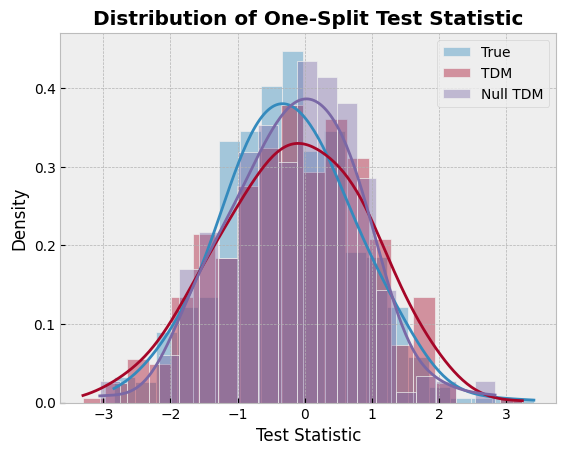

In [13]:
sns_kwargs = {
    "bins": 20,
    "stat": "density",
    "kde": True,
    "alpha": 0.4,
    "kde_kws": {"bw_adjust": 1.5},
}

sns.histplot(test_stat_true, label="True", **sns_kwargs)
sns.histplot(test_stat_learned, label="TDM", **sns_kwargs)
sns.histplot(test_stat_learned_null, label="Null TDM", **sns_kwargs)

plt.legend()
plt.xlabel("Test Statistic")
plt.title("Distribution of One-Split Test Statistic", weight="bold")

True null distribution and learned null distribution are similar, but the learned distribution is a little bit optimistic.

Solution (to be done later, get some inference results with current set up first):
* Have a better pre-trained model (use 5000 instead)
* Have few fine-tuning sample (the larger size, the larger generation error)

## Study on type-I error control and power

* $D = 1000$
* $f^*$ and $g^*$ estimated from synthetic data (twin_1) and validating on true data
* test statistic calculated from the synthetic data (twin_2)


In [9]:
null_features_list = ["num_7"] # ["num_6"] (significant) or ["num_7"] (null feature)


kwargs = {
    "num_features_list": [f"num_{i}" for i in range(8)],
    "iterations": 2000,
    "loss_function": "MAE",
    "verbose": False,
}

temp_parent_dir = "./temp2/" # saving cached samples

# kwargs for generating samples using twin generators
tddpm_kwargs_twin = {twin_kw: {
    "pipeline_config_path": f"./ckpt/{keyword}_{twin_kw}/config.toml",
    "ckpt_path": f"./ckpt/{keyword}_{twin_kw}/model.pt",
    "pipeline_dict_path": os.path.join(ckpt_dir, "pipeline_dict.joblib"), # same as the pre-processing pipeline during its fine-tuning
    "temp_parent_dir": temp_parent_dir,
    "device": f"cuda:{CUDA_ID}",
} for twin_kw in ["twin_1", "twin_2"]}


In [10]:
# Get f* and g* for constructing test statistic

seed_everything(SEED)

generate_sample(num_samples=10 * n_train, batch_size= 10 * n_train, seed = random.randint(0, 100000), **tddpm_kwargs_twin["twin_1"])
df_train = concat_data(temp_parent_dir, split="train")

df_inf = concat_data(raw_data_dir, split="val")

model_full = catboost_pred_model(df_train, df_inf, **kwargs)
model_partial = catboost_pred_model(
    df_train, df_inf, null_features_list=null_features_list, **kwargs
)


print("Full model:", model_full.best_score_)
print("Partial model:", model_partial.best_score_)

Seed set to 2023


Loading numerical preprocessing pipeline from ./ckpt/inf_10000/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10000, 8)
no null features, using all specified features for training


null features ['num_7'] will be removed during training
Full model: {'learn': {'MAE': 0.11732127481213203}, 'validation': {'MAE': 0.16486572519848078}}
Partial model: {'learn': {'MAE': 0.12113551734212036}, 'validation': {'MAE': 0.1651781015783981}}


In [ ]:
# EXPERIMENTAL
# Get null preditors from twin_1 and twin_2 respectively

seed_everything(SEED)

generate_sample(
    num_samples=10 * n_train,
    batch_size=10 * n_train,
    seed=random.randint(0, 100000),
    **tddpm_kwargs_twin["twin_1"]
)
df_train = concat_data(temp_parent_dir, split="train")

df_inf = concat_data(raw_data_dir, split="val")

model_full = catboost_pred_model(df_train, df_inf, **kwargs)
model_partial = catboost_pred_model(
    df_train, df_inf, null_features_list=null_features_list, **kwargs
)


print("Full model:", model_full.best_score_)
print("Partial model:", model_partial.best_score_)

In [10]:
# Setup for the MC experiments

inf_dir = "./results/inf/"
if not os.path.exists(inf_dir):
    os.makedirs(inf_dir)


rho_max = 20
num_rhos = 20
D = 1000


suffix = "_".join(null_features_list)
result_dict = {}
result_dict_save_path = os.path.join(inf_dir, f"result_dict_{suffix}.pkl")


In [ ]:
# Run MC experiments for null distribution, type-I error rate and test statistic under learned true distribution

seed_everything(SEED)

for i, rho in enumerate(np.linspace(0, rho_max, num_rhos + 1)[1:]):
    m = int(rho * n_val)
    print(f"rho: {rho}, m: {m}")

    # Generate samples once for all given a specific m
    start = time.time()
    with HiddenPrints():
        generate_sample(
            num_samples=D * m,
            batch_size=int(D * m / 10),
            seed=random.randint(0, 100000),
            **tddpm_kwargs_twin["twin_1"],
        )
    df_twin_1 = concat_data(temp_parent_dir, split="train")
    print(df_twin_1.shape)

    with HiddenPrints():
        generate_sample(
            num_samples=2 * D * m,
            batch_size=int(2 * D * m / 10),
            seed=random.randint(0, 100000),
            **tddpm_kwargs_twin["twin_2"],
        )
    df_twin_2 = concat_data(temp_parent_dir, split="train")
    print(df_twin_2.shape)

    print(f"Time elapsed: {time.time() - start:.2f} seconds")

    # get null distribution of the test statistic
    null_T_list = []
    for D1 in tqdm(range(D)):
        temp_df = df_twin_1.iloc[D1 * m : (D1 + 1) * m].copy()
        temp_df[null_features_list] = np.random.rand(
            temp_df.shape[0], len(null_features_list)
        )

        test_stat_null = blackbox_test_stat(
            temp_df, model_full, model_partial, **kwargs
        )
        null_T_list.append(test_stat_null)

    # estimate the type-I error rate
    # and calculate the test statistic under learned true distribution
    type1_T_list, learned_true_T_list = [], []
    for D2 in tqdm(range(D)):
        # for estimating type-I error
        temp_df = df_twin_2.iloc[D2 * m : (D2 + 1) * m].copy()
        temp_df[null_features_list] = np.random.rand(
            temp_df.shape[0], len(null_features_list)
        )
        test_stat_null = blackbox_test_stat(
            temp_df, model_full, model_partial, **kwargs
        )
        type1_T_list.append(test_stat_null)

        # the test statistic under learned true distribution
        temp_df = df_twin_2.iloc[(D + D2) * m : (D + D2 + 1) * m].copy()
        test_stat_true = blackbox_test_stat(
            temp_df, model_full, model_partial, **kwargs
        )
        learned_true_T_list.append(test_stat_true)

    # save the null test statistics, as well as the one under learned true distribution
    result_dict[str(rho)] = {
        "m": m,
        "null_dist": null_T_list,
        "type1_test_stat": type1_T_list,
        "learned_true_test_stat": learned_true_T_list,
    }

    pickle.dump(result_dict, open(result_dict_save_path, "wb"))


In [11]:
# power comparision

# p-value using the raw sample

df_train = concat_data(raw_data_dir, split="train")
df_inf = concat_data(raw_data_dir, split="val")


model_full = catboost_pred_model(df_train, df_inf, **kwargs)
model_partial = catboost_pred_model(
    df_train, df_inf, null_features_list=null_features_list, **kwargs
)

test_stat_real = blackbox_test_stat(df_inf, model_full, model_partial, **kwargs)
rv = norm()
p_value = 1 - rv.cdf(test_stat_real)

print("True test statistic:", test_stat_real)
print("Corersponding p-value:", p_value)


no null features, using all specified features for training


null features ['num_7'] will be removed during training
True test statistic: 0.19594580066529502
Corersponding p-value: 0.42232629415737777


In [14]:
# Syn-Test tuning

result_dict = pickle.load(open(result_dict_save_path, "rb"))

# single fold p-value

alpha = 0.05
epsilon = 0.01

rho_list, type_I_error_list = [], []
for k, v_dict in result_dict.items():
    null_dist = np.array(v_dict["null_dist"])
    type1_test_stat = np.array(v_dict["type1_test_stat"])
    # null_dist, type1_test_stat = type1_test_stat, null_dist
    # null_dist, type1_test_stat = bias_correction(null_dist, type1_test_stat, direction = "greater")
    
    p_values = []
    for t in type1_test_stat:
        # p_value = 2 * min(np.mean(null_dist >= t), np.mean(null_dist <= t))
        p_value = np.mean(null_dist >= t)
        p_values.append(p_value)
    type_I_error = np.mean(np.array(p_values) <= alpha - epsilon)
    
    type_I_error_list.append(type_I_error)
    rho_list.append(float(k))

rho_list = np.array(rho_list)
type_I_error_list = np.array(type_I_error_list)


print(rho_list)
print(type_I_error_list)



[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
[0.044 0.032 0.04  0.048 0.031 0.038 0.032 0.028 0.025 0.032 0.036 0.053
 0.038 0.029 0.054 0.03  0.031 0.052 0.035 0.042]


Text(0.5, 1.0, 'Test null feature: Type-I error curve')

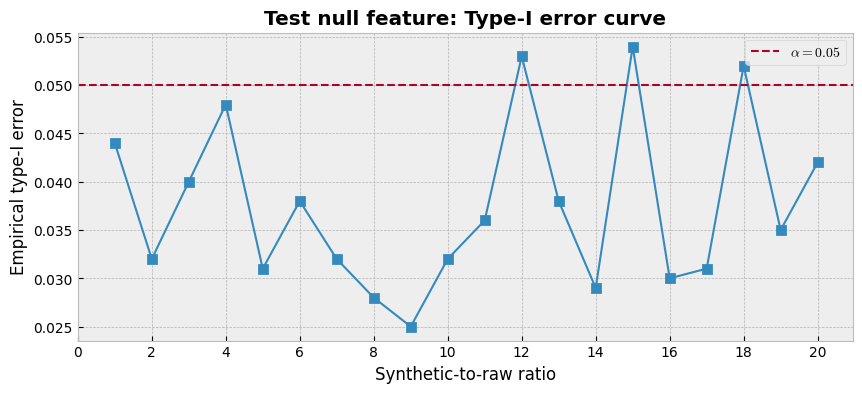

In [15]:
# Visualization

rho_list = np.array(list(result_dict.keys()), dtype=np.float32)


plt.style.use("bmh")

plt.figure(figsize=(10, 4))


plt.plot(
    rho_list,
    type_I_error_list,
    marker="s",
    mew=2,
    linestyle="-",
    markersize=6,
    linewidth=1.5,
)

plt.axhline(alpha, linestyle="--", color="C1", linewidth=1.5, label=r"$\alpha=0.05$")

plt.legend()

plt.xticks(ticks=np.arange(0, 21, 2))
plt.xlabel("Synthetic-to-raw ratio")


plt.ylabel("Empirical type-I error")

plt.title("Test null feature: Type-I error curve", fontweight="bold")



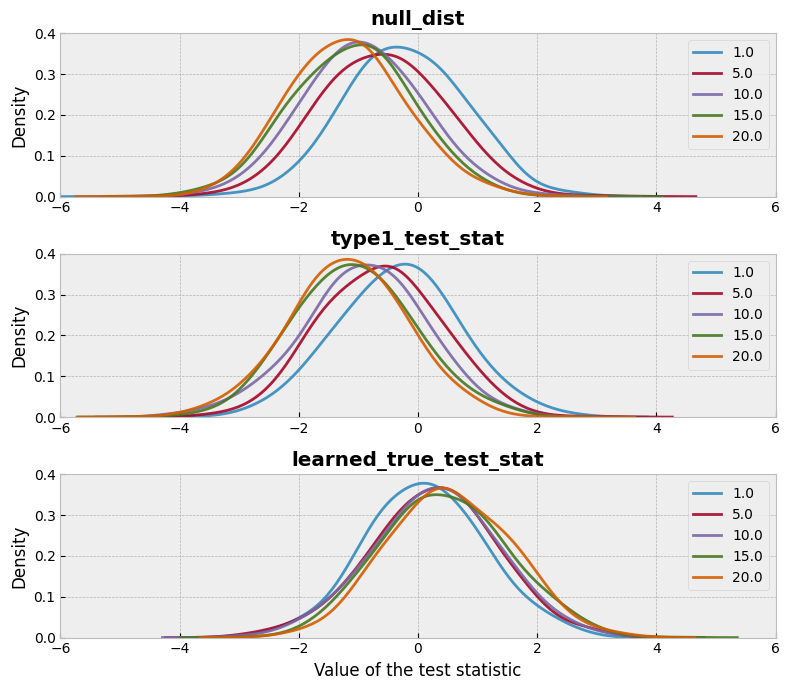

In [25]:
# Distribution of the test statistics w.r.t. different ratios, under the NULL hypothesis, after bias correction



fig, axes = plt.subplots(3, 1, figsize=(8, 7))
axes = axes.flatten()  # Flatten the array for easy indexing

for i, k in enumerate(["null_dist", "type1_test_stat", "learned_true_test_stat"]):
    ax = axes[i]
    for rho in np.array([1.0, 5, 10, 15, 20]):
        temp_data = result_dict[str(rho)][k]
        sns.kdeplot(
            temp_data,
            fill=False,
            label=str(rho),
            alpha=0.9,
            common_grid=True,
            linewidth=2,
            bw_adjust=1.5,
            ax=ax  # Plot on the selected subplot
        )
    ax.set_xlim(-6, 6)
    ax.set_ylim(0, 0.4)
    ax.set_title(k, fontweight="bold")
    if i == 2:
        ax.set_xlabel("Value of the test statistic")
        
    ax.legend()


plt.tight_layout()
plt.show()


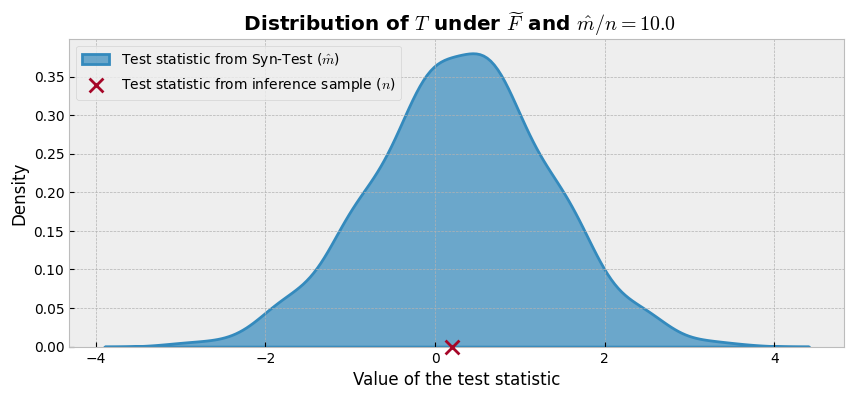

In [28]:
rho = 10.0
test_stat_list = np.array(result_dict[str(rho)]["learned_true_test_stat"])


plt.figure(figsize=(10, 4))
ax = sns.kdeplot(test_stat_list, fill=True, alpha = 0.7, common_grid=True, linewidth=2, label=r"Test statistic from Syn-Test ($\hat m$)")

y_min, y_max = ax.get_ylim()

ax.scatter(x = test_stat_real, y = y_min, marker = 'x', zorder = 10, clip_on = False, s=100, label=r"Test statistic from inference sample ($n$)")

ax.set_ylim(y_min, y_max)

plt.xlabel("Value of the test statistic")
plt.title(fr" Distribution of $T$ under $\widetilde F$ and $\hat m/n = {rho}$", fontweight="bold")
plt.legend(loc="upper left")

**ISSUE: We have issues of type-I error control**

If we check the comparision plot: true and learned null are similar, but learned true is biased to right, two possible reasons:

* The way we construct the learned null generators (directly replace the null feature in the learned true model -> move to "left" )
* Large generation error (to reduce the gap between learned null and learned true under H_0)